**학습전체**
- 머신러닝 또는 딥러닝을 활용해서 데이터를 분류(classification)하는 문제를 풀어봤다.
- 텐서플로우(TensorFlow)가 무엇인지 알며, 이를 활용해서 머신러닝/딥러닝 문제를 풀어봤다.
- 텐서플로우(TensorFlow)가 무엇인지 알며, 이를 활용해서 머신러닝/딥러닝 문제를 풀어봤다.
- python의 기본적인 문법을 알며, 함수 또는 클래스를 다룰 수 있다.

**강아지와 고양이를 구별하는 모델을 학습시켜보자.**


# 이미지 분류 문제

In [ ]:
import tensorflow as tf

tfds.__version__

'4.0.1'

- tensorflow_dataset은 텐서플로우가 제공하는 데이터셋 모음집이다.
- 아래 링크에서 세부 내용을 확인해보자.
https://www.tensorflow.org/datasets/catalog/overview


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# 모델이 학습하기 위해 데이터를 넣어주자

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteA2QB9P/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


- "WARNING:absl:1738 images were corrupted and were skipped"라는 경고가 나타날 수 있습니다. 우선 무시하자.
- `split=['train[:80%]', 'train[80%:90%]', 'train[90%:]']`
- (전체 `train` 데이터셋으로 설정되어 있는 데이터셋을 80%, 10%, 10% 세 부분으로 나누어 각각 `train_data`, `validation_data`, `test_data`로 사용하겠다는 의미이다.)

In [ ]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


**각각의 데이터 셋을 확인해보자.**
- 모든 데이터셋은 (image, label)의 형태를 가진다.
- ((None, None, 3), ())를 나타낸다.
- (None, None, 3)은 image의 shape를, 뒤의 ()는 정답 카테고리인 label의 shape를 의미한다.
- 3차원의 데이터 (height, width, channel)로 이루어져 (None, None, 3)과 같은 형태이다.
- 숫자 3은 색상 RGB를 의미한다.

# 데이터 가공
- 데이터 시각화를 통해 확인하고, 모델에 입력할 수 있는 형태로 전처리하기

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

- 데이터를 확인하기 위해 `matplotlib` 라이브러리를 가져오자.

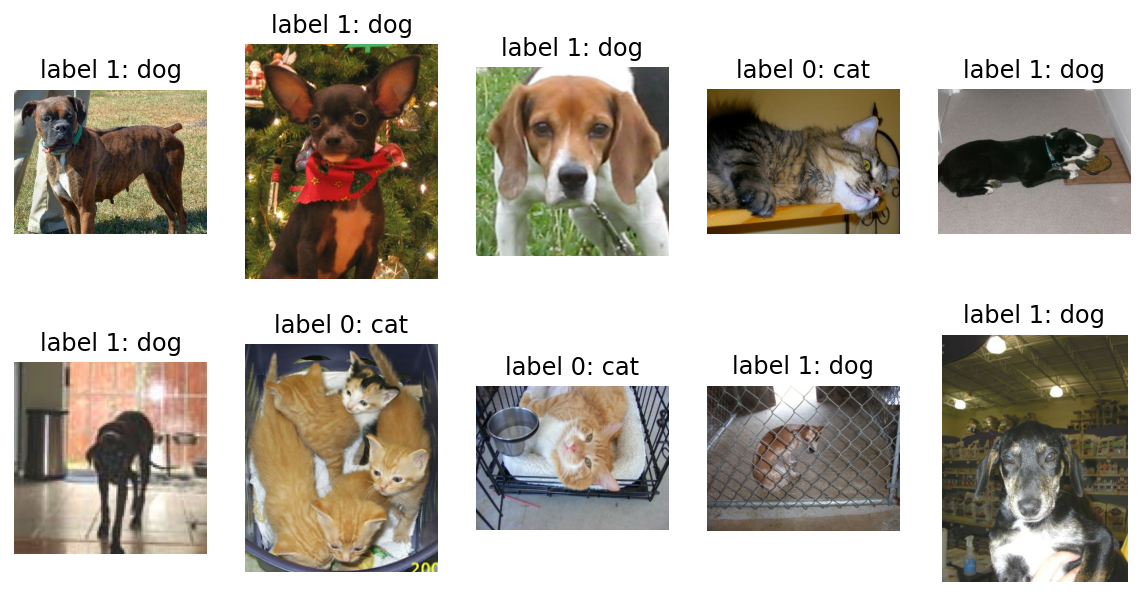

In [ ]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):  # 10개의 데이터를 가져 옵니다.
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

- `raw_train` 안에 있는 데이터를 확인하기 위해 `tf.data.Dataset`에서 제공하는 `take` 함수를 사용하자.
- 이 함수는 인수로 받은 만큼의 개수만큼의 데이터를 추출하여 새로운 데이터셋 인스턴스를 생성하여 리턴하는 함수이다.

- 10장의 사진을 확인해보니 강아지와 고양이 이미지가 잘 섞여있다.
- 강아지는 label 1로 고양이는 label 0
- 이미지의 사이즈는 전부 제각각이므로 전부 통일시켜주는 작업을 해야한다.
- `format_example()` 함수를 사용해 이미지 통일 포맷을 시켜주자.

In [ ]:
IMG_SIZE = 160 # 리사이징할 이미지의 크기

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의  텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 픽셀값의 scale 수정
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

>
타입캐스팅(type Casting): 형변환으로도 불리며 다른 데이터 타입으로 형(타입)을 바꿔주는것으로, 정수형을 실수형으로 바꾸기 위해 `float()`를 사용

In [ ]:
import tensorflow as tf
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print(train)
print(validation)
print(test)

<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>


- `format_example()`함수 `raw_train`, `taw_validation`, `raw_test`에 `map()` 함수로 적용시켜 원하는 모양의 `train`, `validation`, `test` 데이터셋으로 변환시키자.
- [리스트에 map 함수 적용하기](https://lms.aiffel.io/steps2/4128#:~:text=%EB%A7%81%ED%81%AC%EB%A5%BC%20%EC%B0%B8%EA%B3%A0%ED%95%B4%20%EC%A3%BC%EC%84%B8%EC%9A%94.-,%EB%A6%AC%EC%8A%A4%ED%8A%B8%EC%97%90%20map%20%ED%95%A8%EC%88%98%20%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0,-1)
- IMG_SIZE를 160으로 지정해줘서 모든 이미지 크기가 (160, 160, 3)으로 통일

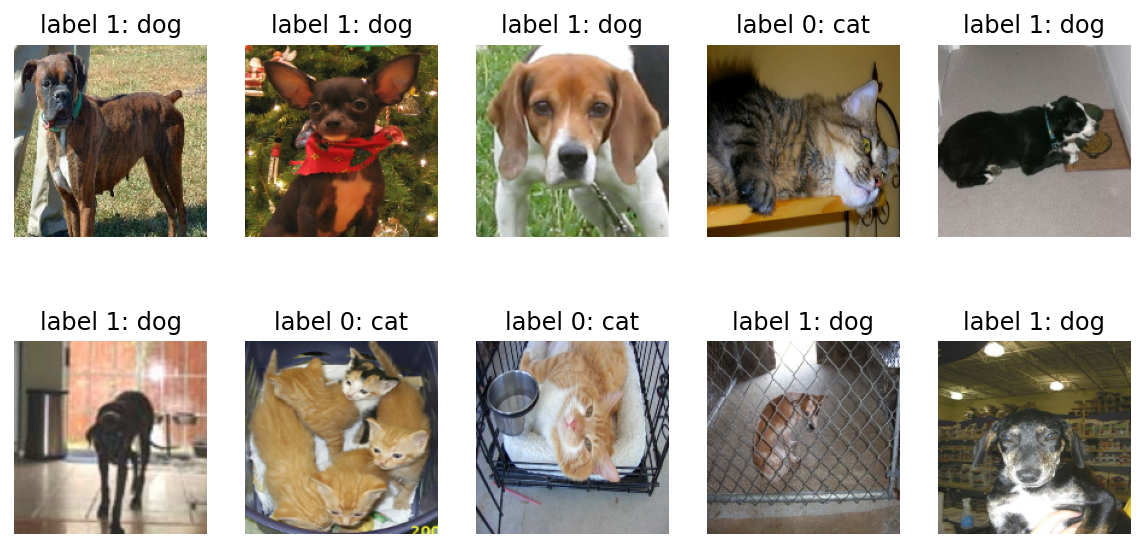

In [ ]:
plt.figure(figsize=(10, 5))


get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

- 이미지를 시각적으로 보니 모든 이미지의 크기가 동일해진 것을 알 수 있다.

# 데이터가 준비되었으니, 모델을 만들어보자
- 텔서플로우 활용하여 모델 구조 설계하기

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,Flatten, MaxPool2D

- 위 두 줄은 각각 models와 layers에서 가져왔다는 차이가 있다.
- models 는 모델 그 자체를 구축하기 위한 함수들을 포함
- layer 에는 모델의 구성 요소인 여러가지 종류의 레이어(layer), 즉 "층"이라는 함수
- sequential 은 "연속적인" 모델을 쌓기 위한 함수(sequential 함수 안에 연속적으로 여러 가지 레이어가 들어간다)

In [ ]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPool2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

- 딥러닝에서의 레이어
- 딥러닝 모델은 언제나 위와 같이 여러 개의 층을 쌓은 형태로 구성
- `Conv2D`, `MaxPooling2D`, `Flatten`, `Dense` 라는 4가지 종류의 레이어를 사용

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 20, 20, 64)       0

- 모델의 전체 구조를 summary로 확인해보자.
- `summary()` 메소드는 모델의 전체 구조를 한눈에 보여준다.
- `summary()` 에 출력된 표는 (160, 160, 3) 크기의 이미지가 모델에 입력된 후 각 레이어를 지나면서 그 이미지의 사이즈가 어떻게 변하는지 보여준다.
- 처음 6개의 레이어를 지난 후 shape는 모두(None, height, width, channel)로 4차원이다.


---
- None 은 배치(batch)사이즈에 따라 모델에 다른 수의 입력이 들어올 수 있음을 나타낸다.
- 데이터 하나의 크기는 (height, width, channel)로 3차원
- 6개의 레이어를 지나면서 height와 width는 점점 작아지고, channel은 점점 커지다가 flatten 계층을 만나 25,600(20 * 20 * 64)이라는 하나의 숫자로, 1차원으로 shape가 줄어든다.

> CNN(Convolution Neural Net)을 사용한 딥러닝 모델의 가장 대표적인 형태
![](https://blogfiles.pstatic.net/MjAyMDA2MjRfOSAg/MDAxNTkyOTMzMzE0NjUx.3K9uzTXWuKHSNivRcXAwnoQGVA66zsUY4R5JqIZgyzMg.Y-xRmUR6QxNTcKpelMzMBLK499RPBZ2UudzqOaOeDrwg.PNG.dsz08082/image.png)

# 데이터를 통해 모델 학습
- 모델 compile 완료 후 학습시키기

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

- 모델이 학습에 필요한 "학습률"(learining_rate)이라는 파라미터를 0.0001로 설정
- 모델을 compile 하여 학습할 수 있는 형태로 변환

---

- compile 을 하기 위해서는 세 가지가 필요하다.(optimizer, loss, metrics)
- optimizer: 학습을 어떤 방식으로 시킬 것인지, 
> 어떻게 최적화시킬 것인지 결정하기 때문에 최적화 함수라 한다.
- loss: 모델이 학습해나가야 하는 방향, 
> 모델의 출력은 고양이인지 강아지인지에 대한 확률분포로 두어서 입력 이미지가 고양이 (label=0)일 경우 모델의 출력이 [1.0, 0.0]에 가깝도록, 강아지(label=1)일 경우 [0.0, 1.0]에  가깝게 방향을 제시
- metrics: 모델의 성능을 평가하는 척도,
> 분류 문제를 풀때, 성능을 평가할 수 있는 지표는 정확도(accuracy), 정밀도(precision), 재현율(recall)
- [성능 평가 지표](https://sumniya.tistory.com/26)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

- 한 스템에 학습시킬 데이터의 개수인 `BATCH_SIZE` 와 학습 데이터를 적절히 섞어줄 `SHUFFLE_BUFFER_SIZE`를 설정

In [ ]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

- `BATCH_SIZE` 에 따라 32개의 데이터를 랜덤으로 뿌려줄 `train_batches`, `validation_batches`, `test_batches`를 만든다.
- `train_batches는 모델이 계속 학습할 수 있도록 전체 데이터에서 32개씩 랜덤으로 뽑아 계속 제공

In [ ]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

- `train_batches 에서 하나의 batch만 꺼내 데이터를 확인해보자.
- `image_batch`의 shape는 `[32, 160, 160, 3]`이며,
- `label_batch`의 shape는 `[32]`이다.
- 즉, 데이터 하나의 크기는 (160, 160, 3)이고, 그 개수가 32개이다.
- label은 강아지이면 1, 고양이이면 0으로 정답 label을 나타내기 때문에 한 batch에 데이터가 32개라면 label은 0 또는 1의 32개의 숫자로만 구성된다.

# 모델을 학습시키기 전에, 초기 모델의 성능확인

In [ ]:
validation_steps = 20
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 2s 76ms/step - loss: 0.7668 - accuracy: 0.7734
initial loss: 0.77
initial accuracy: 0.77


- validation(검증)을 하기 위한 데이터셋인 `validation_batches`을 이용해 20번의 예측을 해보고, 평균 `loss`와 평균 `accuracy`를 확인해보자.
- `loss`는 0.7, `accuracy`는 약 77%
- `loss` : "손실", 얼마나 모델이 틀렸는지를 나타내며 낮을수록 좋은 것
- `accuracy` : 몇 퍼센트의 정확도

In [ ]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 70s 114ms/step - loss: 0.5962 - accuracy: 0.6710 - val_loss: 0.5477 - val_accuracy: 0.7287
Epoch 2/10
582/582 [==============================] - 66s 110ms/step - loss: 0.4857 - accuracy: 0.7658 - val_loss: 0.4852 - val_accuracy: 0.7752
Epoch 3/10
582/582 [==============================] - 67s 112ms/step - loss: 0.4224 - accuracy: 0.8070 - val_loss: 0.4713 - val_accuracy: 0.7807
Epoch 4/10
582/582 [==============================] - 67s 112ms/step - loss: 0.3703 - accuracy: 0.8352 - val_loss: 0.4733 - val_accuracy: 0.7919
Epoch 5/10
582/582 [==============================] - 67s 112ms/step - loss: 0.3158 - accuracy: 0.8664 - val_loss: 0.4767 - val_accuracy: 0.7816
Epoch 6/10
582/582 [==============================] - 67s 112ms/step - loss: 0.2687 - accuracy: 0.8883 - val_loss: 0.4920 - val_accuracy: 0.7889
Epoch 7/10
582/582 [==============================] - 67s 112ms/step - loss: 0.2149 - accuracy: 0.9166 - val_loss: 0.5070 - val_ac

- 10 epoch를 학습시켜 정확도가 얼마나 나오는지 확인해보자.
1. `accuracy` 는 훈련 데이터셋에 대한 정확도, 학습하고 있는 데이터에 대한 정확도
2. `val_accuracy`는 검증 데이터셋의 정확도, 학습하지 않은 데이터에 대한 정확도


---
- 훈련 데이터셋에 대한 정확도가 높은 것이 당연하다.


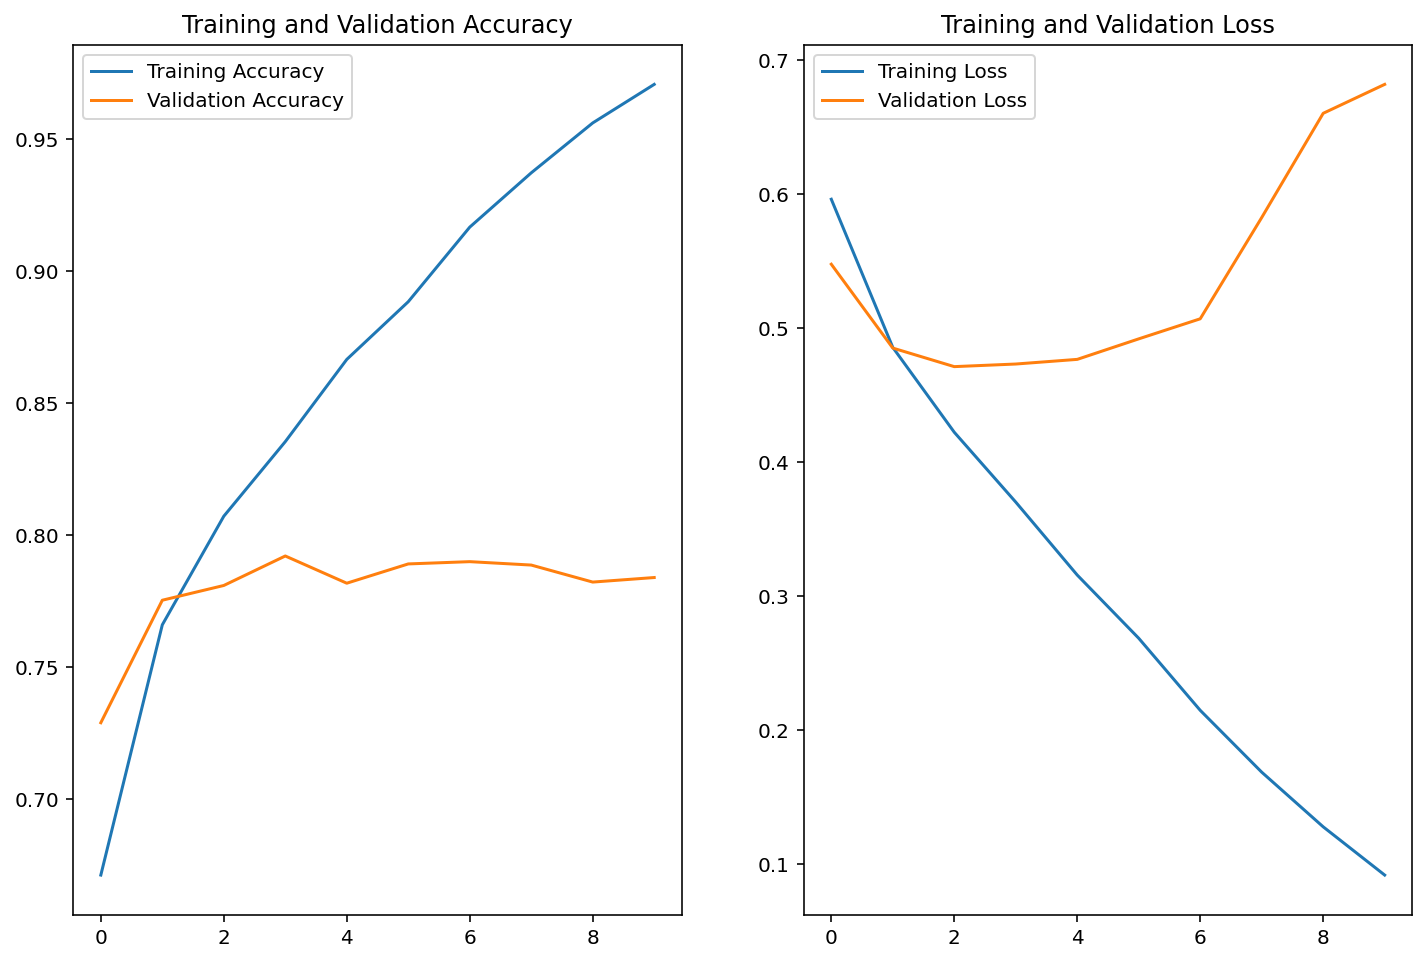

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

- 10 epoch를 모두 학습한 후 훈련 데이터셋에 대한 정확도 는 90% 이상
- 검증 데이터셋에 대한 accuracy는 약 78%
> 학습 단계에 따른 정확도 변화 그래프로 확인해보자


---

###과적합(Overfitting, 오버피팅)
- training accuracy는 꾸준히 오르지만 validation accuracy는 어떤 한계선을 넘지 못한다.
-  loss 그래프에서 training loss는 계속 안정적으로 줄어들지만, validation loss값은 특정 순간 이후로 다시 커지는 모습이 보인다.

In [ ]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9997175e-01, 2.8215802e-05],
       [9.9707448e-01, 2.9254921e-03],
       [7.2595781e-01, 2.7404219e-01],
       [9.9998713e-01, 1.2815235e-05],
       [9.9452764e-01, 5.4723988e-03],
       [7.2527909e-01, 2.7472091e-01],
       [1.8550041e-01, 8.1449962e-01],
       [9.7930759e-01, 2.0692352e-02],
       [5.6431448e-01, 4.3568558e-01],
       [4.2713773e-01, 5.7286227e-01],
       [9.1492361e-01, 8.5076407e-02],
       [9.9994493e-01, 5.5077347e-05],
       [9.9923801e-01, 7.6197647e-04],
       [3.0298246e-02, 9.6970177e-01],
       [9.9967754e-01, 3.2243587e-04],
       [9.9995303e-01, 4.6970123e-05],
       [9.2797911e-01, 7.2020881e-02],
       [1.4829182e-04, 9.9985170e-01],
       [9.7827679e-01, 2.1723246e-02],
       [2.5708482e-01, 7.4291521e-01],
       [9.9970442e-01, 2.9554518e-04],
       [9.9939215e-01, 6.0788618e-04],
       [9.9997890e-01, 2.1157028e-05],
       [9.8317796e-01, 1.6822102e-02],
       [9.9673456e-01, 3.2654046e-03],
       [7.0187956e-01, 2.

- `predictions` 는 소수점으로 이루어짐
- 이 값은 모델이 판단한 `[고양이일 확률, 강아지일 확률]`로 `[1.0, 0.0]`에 가까울수록 label이 0인 고양이, `[0.0, 1.0]`에 가까울수록 label이 1인 강아지로 예측한 것이다.

In [ ]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

- 32장의 image들과 32개의 label, 그리고 32개의 predictions을 알았으니 각각을 시각화해보자.

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
count = 0   # 정답을 맞춘 개수
for image, label, prediction in zip(images, labels, predictions):
    correct = label == prediction
    if correct:
        count = count + 1
print(count / 32 * 100)
print(count)

78.125
25


- 몇개가 맞았는지 확인해보자.